In [117]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar  9 20:17:32 2024

@author: 19352
"""

# -*- coding: utf-8 -*-
"""
Created on Tue Mar  5 18:30:45 2024

@author: 19352
"""

import requests
from datetime import date,datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io
import os 
####################################
##TO DO：fill up your path of data##
####################################
os.chdir("/Users/fengtingyu/Desktop/backtesting_uncompletely/")


####################################
####################################
import pickle
import copy

from pandas.tseries.offsets import DateOffset

####################################
####################################

from pandas import Series, DataFrame
import numpy as np
from datetime import datetime,timedelta
import time
from sklearn import preprocessing
from scipy.stats import mstats
import scipy.stats as st
import seaborn as sns
import calendar
import statsmodels.api as sm
import matplotlib.pylab as plt
import xlrd
import itertools
import copy
import pickle
import warnings
from scipy import stats



#%matplotlib inline

In [158]:
class Exchange:
    
    def __init__(self, trade_symbols, fee=0.0004, initial_balance=10000):
    
        self.initial_balance = initial_balance #初始的资产
        self.fee = fee #交易费用
        self.trade_symbols = trade_symbols #所有可交易的股票代码
        self.recording=pd.DataFrame(columns=[''])
        self.account = {'RMB':{'realised_profit':0, 'unrealised_profit':0, 'total_asset':initial_balance, 'fee':0, 'leverage':0, 'hold':0}}
        '''
        现金账户
        unrealised_profit：浮盈总计
        hold：总持有股票市值
        leverage：总持有股票市值/总资产
        '''
        
        
        for symbol in trade_symbols:
            self.account[symbol] = {'amount':0, 'hold_price':0, 'value':0, 'price':0, 'realised_profit':0,'unrealised_profit':0,'fee':0}
            '''
            amount:持有数量
            hold_price:持有价格
            price:现价
            realised_profit：
            unrealised_profit:浮盈价格
            '''
            
    def Trade(self, symbol, direction, price, amount):
        
        cover_amount = 0 if direction*self.account[symbol]['amount'] >=0 else min(abs(self.account[symbol]['amount']), amount)
        #判断是否需要先平仓以及需要平仓的仓位
        
        open_amount = amount - cover_amount
        #判断是否需要开仓，开仓的话需要开多少
        if not np.isnan(price):
            self.account['RMB']['realised_profit'] -= price*amount*self.fee #扣除手续费
            self.account['RMB']['fee'] += price*amount*self.fee
            self.account[symbol]['fee'] += price*amount*self.fee

        if cover_amount > 0: #先平仓
            if not np.isnan(price):
                self.account['RMB']['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount  #利润
                self.account[symbol]['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount
                
                self.account[symbol]['amount'] -= -direction*cover_amount
                self.account[symbol]['hold_price'] = 0 if self.account[symbol]['amount'] == 0 else self.account[symbol]['hold_price']
            else:
                self.account['RMB']['realised_profit'] += -direction*( 0 )*cover_amount  #利润
                self.account[symbol]['realised_profit'] += -direction*( 0 )*cover_amount
                
                self.account[symbol]['amount'] -= -direction*cover_amount
                self.account[symbol]['hold_price'] = 0 if self.account[symbol]['amount'] == 0 else self.account[symbol]['hold_price']
                
        if open_amount > 0:
            if not np.isnan(price):
                total_cost = self.account[symbol]['hold_price']*direction*self.account[symbol]['amount'] + price*open_amount
                total_amount = direction*self.account[symbol]['amount']+open_amount
                
                self.account[symbol]['hold_price'] = total_cost/total_amount
                self.account[symbol]['amount'] += direction*open_amount
                        
        
    def Buy(self, symbol, price, amount):
        self.Trade(symbol, 1, price, amount)
        
    def Sell(self, symbol, price, amount):
        self.Trade(symbol, -1, price, amount)
        
    def Update(self, open_price): #对资产进行更新
        self.account['RMB']['unrealised_profit'] = 0
        self.account['RMB']['hold'] = 0
        for symbol in self.trade_symbols:
            if not np.isnan(open_price[symbol]):
                self.account[symbol]['unrealised_profit'] = (open_price[symbol] - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
                #（现价-买入价）*持有数量
                self.account[symbol]['price'] = open_price[symbol]
                self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*open_price[symbol]
                #持有数量*现价
                self.account['RMB']['hold'] += self.account[symbol]['value']
                
                self.account['RMB']['unrealised_profit'] += self.account[symbol]['unrealised_profit']

#         self.account['RMB']['total_asset'] = round(self.account['RMB']['realised_profit'] + self.account['RMB']['hold'],6)
#         self.account['RMB']['total_profit'] = round(self.account['RMB']['realised_profit']+ self.account['RMB']['unrealised_profit'],6)
        self.account['RMB']['total_asset'] =round(self.account['RMB']['realised_profit'] + self.initial_balance+self.account['RMB']['unrealised_profit'],6)
        self.account['RMB']['leverage'] = round(self.account['RMB']['hold']/self.account['RMB']['total_asset'],3)
        
    def preUpdate(self,open_price): #在每期调仓前获得当期的可使用资金
        hold_asset=0
        for symbol in self.trade_symbols:
            if not np.isnan(open_price[symbol]):
                unrealised_profit = (open_price[symbol] - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
                #持有数量*现价=价值敞口
                hold_asset += unrealised_profit
        usable_asset= round(self.account['RMB']['realised_profit'] + self.initial_balance+ hold_asset,6)  
        return usable_asset



In [172]:
def Test(factor, symbols, df_open,freq=1,buy_sign = 0.1, sell_sign = 0.1, initial_balance=1000000,group=0):
    ### 添加group变量输入，用于区分是否分组，若group=0，则只持有一组资产，若group=1，则说明持有多组资产 -冯婷玉
    '''
    factor_df: 因子值的dataframe，index需为pd.datetime类型的日期
    symbols_stock   具有因子值的所有股票的ID，类型为list
    open_df   每个月开盘价的dataframe，index需为pd.datetime类型的日期
    risk_free_file 无风险利率的文件名
    freq  多久重新构造投资组合一次，目前支持的输入有：‘July’-> 每年7月初更新；数字1-12->每1-12个月更新一次
    buy_sign： 做多因子值前百分之几的股票，默认为做多前10%，即0.1。
    
    返回值：
    1.因子的持仓的资产净值
    '''
    e = Exchange(symbols, fee=0.001, initial_balance=initial_balance)
    res_list = []
    index_list = []
    factor = factor.dropna(how='all')
    buy_symbols = []
    usable_assetlist=[]
    trigger=0

    if freq == 'July': ####对于调仓时间固定为每年7月的因子进行回测
        for idx, row in df_open.iterrows():
            if idx.month!=7:
                continue
            prices = df_open.loc[idx,]
            index_list.append(idx)
            
            if trigger>=1:
                usable_asset=e.preUpdate(prices)
                usable_assetlist.append(usable_asset)
                
            if idx in factor.index:
                trigger+=1
                rrow = factor.loc[idx, ]
                buy_symbols =  rrow.dropna()[rrow.dropna() > rrow.dropna().quantile((1-buy_sign))].index

                    
                if len(buy_symbols)!=0:
                    number_buy_symbols=len(buy_symbols)
                    if trigger==1:
                        cash_position=(initial_balance/number_buy_symbols)
                    else:
                        cash_position=(usable_asset/number_buy_symbols)   
                    if cash_position<=0:
                        cash_position=0
                        buy_symbols=[]
            
            for symbol in symbols:
                if symbol in buy_symbols and e.account[symbol]['amount'] <= 0:
                    e.Buy(symbol,prices[symbol],(cash_position/prices[symbol])-e.account[symbol]['amount'])
                if symbol not in buy_symbols and e.account[symbol]['amount'] >= 0:
                    e.Sell(symbol,prices[symbol], e.account[symbol]['amount'])
            e.Update(prices)
            res_list.append([e.account['RMB']['total_asset']])
        output=pd.DataFrame(data=res_list, columns=['total_asset'],index = index_list)
        return output

    else: ####对于调仓时间间隔为1，3，6，9，12个月的因子进行回测
        for idx, row in df_open.iterrows():
            prices = df_open.loc[idx,]
            # index_list.append(idx)
            if trigger>=1:
                months_apart = (idx.year - first_transaction_time.year) * 12 + (idx.month - first_transaction_time.month)
                if months_apart%freq != 0:
                    continue
                usable_asset=e.preUpdate(prices)
                usable_assetlist.append(usable_asset)
            index_list.append(idx)    
            if idx in factor.index:  
                rrow = factor.loc[idx, ]
                if group== 0 :  #####冯婷玉添加
                    buy_symbols =  rrow.dropna()[rrow.dropna() > rrow.dropna().quantile(buy_sign)].index
                else:  ####冯婷玉添加
                    buy_symbols =  rrow.dropna()[(rrow.dropna() > rrow.dropna().quantile(buy_sign-0.1))&(rrow.dropna() < rrow.dropna().quantile(buy_sign))].index
                if len(buy_symbols)!=0:
                    trigger+=1
                    number_buy_symbols=len(buy_symbols)
                    if trigger==1:
                        cash_position=(initial_balance/number_buy_symbols)
                        first_transaction_time=idx
                    else:
                        cash_position=(usable_asset/number_buy_symbols)
                        
                    if cash_position<=0:
                        cash_position=0
                        buy_symbols=[]

            
            for symbol in symbols:
                if symbol in buy_symbols and e.account[symbol]['amount'] <= 0:
                    e.Buy(symbol,prices[symbol],(cash_position/prices[symbol])-e.account[symbol]['amount'])
                if symbol not in buy_symbols and e.account[symbol]['amount'] >= 0:
                    e.Sell(symbol,prices[symbol], e.account[symbol]['amount'])
            e.Update(prices)
            res_list.append([e.account['RMB']['total_asset']])
            #res_list.append([e.account['RMB']['total_asset'],e.account['RMB']['total_profit']])
    
        #output=pd.DataFrame(data=res_list, columns=['total_asset','total_profit'],index = index_list)
        output=pd.DataFrame(data=res_list, columns=['total_asset'],index = index_list)

    return output


In [160]:
def mainbody(factor_df,symbols_stock,open_df,risk_free_file,freq=1,buy_sign=0.1,group=0):
### 添加group变量输入，用于区分是否分组，若group=0，则只持有一组资产，若group=1，则说明持有多组资产 -冯婷玉:  
    '''
    factor_df: 因子值的dataframe，index需为pd.datetime类型的日期
    symbols_stock   具有因子值的所有股票的ID，类型为list
    open_df   每个月开盘价的dataframe，index需为pd.datetime类型的日期
    risk_free_file 无风险利率的文件名
    freq  多久重新构造投资组合一次，目前支持的输入有：‘July’-> 每年7月初更新；数字1-12->每1-12个月更新一次
    buy_sign： 做多因子值前百分之几的股票，默认为做多前10%，即0.1。
    
    返回值：
    1.净资产df
    2.年华收益率
    3.夏普率
    4.最大回测
    '''
    if group==0:   ####冯婷玉添加
        factor_res = Test(factor_df, symbols_stock,open_df,freq=freq,buy_sign=buy_sign) ####冯婷玉添加
    else:
        factor_res = Test(factor_df, symbols_stock,open_df,freq=freq,buy_sign=buy_sign,group=1)  ###冯婷玉添加
    # factor_res['total_asset'].plot(figsize=(15,6),grid=True).get_figure().savefig('WMYC_all.png')
    i = np.argmax((factor_res['total_asset'].cummax() - factor_res['total_asset'])) # 最大回撤结束的位置 最低的那个位置
    if i == 0:
        j = 0
    else:
        j = np.argmax(factor_res['total_asset'][:i])  # 回撤开始的位置 最高的那个点
    maxdrawdown = (factor_res['total_asset'].cummax() - factor_res['total_asset']).max() # 最大回撤
    maxdrawdown_rate = ((factor_res['total_asset'].cummax() - factor_res['total_asset']) / factor_res['total_asset'].cummax()).max() # 最大回撤率
    drawdown_days = i - j # 回撤持续天数
    # print('最大回撤率：', maxdrawdown_rate)
    # print('回撤持续天数：', drawdown_days)
    ####################
    # 夏普率
    risk_free_file=risk_free_file #无风险收益文件
    risk_free = pd.read_excel(risk_free_file).iloc[2:,:]
    risk_free['Trdmnt'] = pd.to_datetime(risk_free['Trdmnt'])
    risk_free.set_index('Trdmnt',inplace=True)
    df_sharp = pd.merge(factor_res, risk_free, left_index=True, right_index=True,how='left')
    df_sharp['return'] = [ (i/1000000)-1 for i in df_sharp.iloc[:,0]]

    # df_sharp=df_sharp[df_sharp['total_asset']>0].iloc[1:,:]
    # print(type(df_sharp.iloc[-1,2]),type(df_sharp['return']),type(len(df_sharp['return'])))
    if freq == 'July' or freq==12 :
        annual_return=  ((1+df_sharp.iloc[-1,2])**(1/len(df_sharp['return'])))-1
        sharp_ration = (annual_return-df_sharp['Interest'].mean()) / df_sharp['return'].std()

    else:
        annual_return=  (df_sharp.iloc[-1,2]/len(df_sharp['return']))*(12/freq)
        sharp_ration = (annual_return-df_sharp['Interest'].mean()) / (df_sharp['return'].std()*np.sqrt(12/freq))
    # print('夏普率：', sharp_ration)
    
    # sharp_ration = (df_sharp['return'].mean() ) / df_sharp['return'].std()
    # df_sharp=pd.DataFrame()
    # df_sharp['return']=factor_res['total_asset'].pct_change()
    # sharp_ration=df_sharp['return'].mean()  / df_sharp['return'].std()
    # print('夏普率：', sharp_ration)
    
    return factor_res,annual_return,sharp_ration,maxdrawdown_rate

In [5]:
df1 = pd.read_csv("SueAM_200001202312.csv")  ##因子文件
df1

,Stkcd,Trdmnt,SueM
0,1,2003-09,-0.456200
1,1,2003-10,-0.456200
2,1,2003-11,-1.094897
3,1,2003-12,-1.094897
4,1,2004-01,-1.094897
...,...,...,...
567590,873593,2023-06,0.566915
567591,873593,2023-07,0.566915
567592,873593,2023-08,0.566915
567593,873593,2023-09,-0.015467


In [6]:
df2 = pd.read_csv("close_price.csv",encoding='gbk',low_memory=False)  ##月度收益率文件
df2

,Stkcd,Trdmnt,Mopnprc,Mclsprc,Mnshrtrd,Msmvosd,Msmvttl,ChangeRatioM
0,证券代码,交易月份,月开盘价,月收盘价,月个股交易股数,月个股流通市值,月个股总市值,月涨跌幅
1,没有单位,没有单位,元/股,元/股,股,千元,千元,没有单位
2,000001,1991-04,49,43.68,13400,1157520,2118487.47,-0.108571429
3,000001,1991-05,43.46,38.34,187800,1016010,1859496.56,-0.11780948
4,000001,1991-06,38.53,33.99,30600,900735,1648520.81,-0.117830262
...,...,...,...,...,...,...,...,...
736641,873726,2023-10,24.45,21.8,11052697,453391.08,1789283.96,-0.108384458
736642,873726,2023-11,21.9,29.15,29840651,508417.28,2392551.72,0.331050228
736643,873726,2023-12,29.28,43.64,47789769,761143.39,3581851.02,0.490437158
736644,873833,2023-11,16.51,14.25,87428760,377740.44,1147980,-0.136886735


In [7]:
###########################################################
##TO DO：fill up the name of factor in factor file of csv##
###########################################################

facotr_name='SueM' #excel文件中因子的列名称

In [8]:
risk_free_file='Rf.xlsx' #无风险收益文件的名字

file_name='Sue' 
'''
输出文件夹和excel的名称
需提前在当前文件夹下创立名字为result的文件夹，然后在result的文件夹内创建与该file_name相同名字的文件夹
'''

'\n输出文件夹和excel的名称\n需提前在当前文件夹下创立名字为result的文件夹，然后在result的文件夹内创建与该file_name相同名字的文件夹\n'

In [9]:
##################
#####mainbody#####
##################
# df1 = df1.drop('Unnamed: 3', axis=1)

# df1['Trdmnt'] = pd.to_datetime(df1['Trdmnt'],format='%b-%y') #format可能需要根据实际excel中时间的类型进行修改
df1['Trdmnt'] = pd.to_datetime(df1['Trdmnt'])
#df1["Trdmnt"] = df1["Trdmnt"].apply(lambda x: x + eval("DateOffset(days=1)"))
df1['Stkcd'] = df1['Stkcd'].astype(str).str.zfill(6)
# df1['Ami']=df1.groupby('Stkcd')['Ami'].shift(1)
df1

,Stkcd,Trdmnt,SueM
0,000001,2003-09-01,-0.456200
1,000001,2003-10-01,-0.456200
2,000001,2003-11-01,-1.094897
3,000001,2003-12-01,-1.094897
4,000001,2004-01-01,-1.094897
...,...,...,...
567590,873593,2023-06-01,0.566915
567591,873593,2023-07-01,0.566915
567592,873593,2023-08-01,0.566915
567593,873593,2023-09-01,-0.015467


In [10]:
df2 = df2[2:]

In [11]:
df2

,Stkcd,Trdmnt,Mopnprc,Mclsprc,Mnshrtrd,Msmvosd,Msmvttl,ChangeRatioM
2,000001,1991-04,49,43.68,13400,1157520,2118487.47,-0.108571429
3,000001,1991-05,43.46,38.34,187800,1016010,1859496.56,-0.11780948
4,000001,1991-06,38.53,33.99,30600,900735,1648520.81,-0.117830262
5,000001,1991-07,33.65,29.54,6100,782810,1432695.05,-0.122139673
6,000001,1991-08,29.39,15,3243100,674833.82,1346274.65,-0.489622321
...,...,...,...,...,...,...,...,...
736641,873726,2023-10,24.45,21.8,11052697,453391.08,1789283.96,-0.108384458
736642,873726,2023-11,21.9,29.15,29840651,508417.28,2392551.72,0.331050228
736643,873726,2023-12,29.28,43.64,47789769,761143.39,3581851.02,0.490437158
736644,873833,2023-11,16.51,14.25,87428760,377740.44,1147980,-0.136886735


In [12]:
df2['Stkcd'] = df2['Stkcd'].astype(str).str.zfill(6)
df2.rename(columns = {'Mopnprc': 'open', "Mclsprc": 'close'}, inplace = True )
df2['Trdmnt'] = pd.to_datetime(df2['Trdmnt'])

/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/639925028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Stkcd'] = df2['Stkcd'].astype(str).str.zfill(6)
/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/639925028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename(columns = {'Mopnprc': 'open', "Mclsprc": 'close'}, inplace = True )
/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/639925028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [13]:
data = pd.merge(df2,df1, on = ['Stkcd','Trdmnt'], how = 'left')

In [14]:
data

,Stkcd,Trdmnt,open,close,Mnshrtrd,Msmvosd,Msmvttl,ChangeRatioM,SueM
0,000001,1991-04-01,49,43.68,13400,1157520,2118487.47,-0.108571429,NaN
1,000001,1991-05-01,43.46,38.34,187800,1016010,1859496.56,-0.11780948,NaN
2,000001,1991-06-01,38.53,33.99,30600,900735,1648520.81,-0.117830262,NaN
3,000001,1991-07-01,33.65,29.54,6100,782810,1432695.05,-0.122139673,NaN
4,000001,1991-08-01,29.39,15,3243100,674833.82,1346274.65,-0.489622321,NaN
...,...,...,...,...,...,...,...,...,...
736823,873726,2023-10-01,24.45,21.8,11052697,453391.08,1789283.96,-0.108384458,NaN
736824,873726,2023-11-01,21.9,29.15,29840651,508417.28,2392551.72,0.331050228,NaN
736825,873726,2023-12-01,29.28,43.64,47789769,761143.39,3581851.02,0.490437158,NaN
736826,873833,2023-11-01,16.51,14.25,87428760,377740.44,1147980,-0.136886735,NaN


In [15]:
symbols = set(data['Stkcd'])
data.rename(columns= {'Mopnprc': 'open', "Mclsprc": 'close', "Mretwd": 'ret'}, inplace=True)
data['Trdmnt'] = pd.to_datetime(data['Trdmnt'])
data.drop_duplicates()

,Stkcd,Trdmnt,open,close,Mnshrtrd,Msmvosd,Msmvttl,ChangeRatioM,SueM
0,000001,1991-04-01,49,43.68,13400,1157520,2118487.47,-0.108571429,NaN
1,000001,1991-05-01,43.46,38.34,187800,1016010,1859496.56,-0.11780948,NaN
2,000001,1991-06-01,38.53,33.99,30600,900735,1648520.81,-0.117830262,NaN
3,000001,1991-07-01,33.65,29.54,6100,782810,1432695.05,-0.122139673,NaN
4,000001,1991-08-01,29.39,15,3243100,674833.82,1346274.65,-0.489622321,NaN
...,...,...,...,...,...,...,...,...,...
736823,873726,2023-10-01,24.45,21.8,11052697,453391.08,1789283.96,-0.108384458,NaN
736824,873726,2023-11-01,21.9,29.15,29840651,508417.28,2392551.72,0.331050228,NaN
736825,873726,2023-12-01,29.28,43.64,47789769,761143.39,3581851.02,0.490437158,NaN
736826,873833,2023-11-01,16.51,14.25,87428760,377740.44,1147980,-0.136886735,NaN


In [16]:
start_date = '2000-01-01'
end_date = '2023-12-01'
period = '1MS'
df_dict = {}
df_factor = pd.DataFrame(index = pd.date_range(start = start_date, end = end_date, freq = period), columns = df_dict.keys())
df_close = pd.DataFrame(index = pd.date_range(start = start_date, end = end_date, freq = period), columns = df_dict.keys())
df_open = pd.DataFrame(index = pd.date_range(start = start_date, end = end_date, freq = period), columns = df_dict.keys())
df_return = pd.DataFrame(index = pd.date_range(start = start_date, end = end_date, freq = period), columns = df_dict.keys())  ####获取回报率数据-冯婷玉
df_weight = pd.DataFrame(index = pd.date_range(start = start_date, end = end_date, freq = period), columns = df_dict.keys())  ####获取流通市值数据-冯婷玉

In [17]:
df_factor

""
2000-01-01
2000-02-01
2000-03-01
2000-04-01
2000-05-01
...
2023-08-01
2023-09-01
2023-10-01
2023-11-01


In [21]:
for symbol in symbols:
    df_s = data[data['Stkcd'] == symbol]
    df_s.set_index(keys='Trdmnt',inplace=True)
    df_s=df_s[~df_s.index.duplicated()]
    if not df_s.empty:
        df_factor[symbol] = df_s[facotr_name]
        df_close[symbol] = df_s['close']
        df_open[symbol] = df_s['open']
        df_return[symbol] = df_s['ChangeRatioM']  #####冯婷玉添加
        df_weight[symbol] = df_s['Msmvosd']   ####冯婷玉添加

/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/3253544630.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_factor[symbol] = df_s[facotr_name]
/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/3253544630.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_factor[symbol] = df_s[facotr_name]
/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/3253544630.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

KeyboardInterrupt: 

In [22]:
df_factor

,300394,836826,603085,603052,000613,603069,300130,600880,603801,301046,...,000686,002558,002022,301015,002439,002935,600258,300772,603612,601857
2003-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,0.282672,-0.890020,-0.115114,NaN,NaN,-0.354251,0.445195,0.050651,0.005511,-0.255935,...,1.072744,-0.324288,0.136665,1.209591,0.301345,0.161233,0.620308,-0.447031,-2.609449,0.187988
2023-08-01,0.282672,-0.890020,-0.115114,NaN,NaN,-0.354251,0.445195,0.050651,0.005511,-0.255935,...,1.072744,-0.324288,0.136665,1.209591,0.301345,0.161233,0.620308,-0.447031,-2.609449,0.187988
2023-09-01,1.989652,-0.394573,-0.108322,NaN,NaN,-0.290340,1.488559,-0.630482,0.464293,-0.329293,...,0.483755,2.945540,0.024657,3.366445,4.172659,-2.163100,1.323376,-1.442501,-3.836984,0.094697
2023-10-01,1.989652,-0.394573,-0.108322,NaN,NaN,-0.290340,1.488559,-0.630482,0.464293,-0.329293,...,0.483755,2.945540,0.024657,3.366445,4.172659,-2.163100,1.323376,-1.442501,-3.836984,0.094697


In [24]:
df_factor = df_factor.dropna(how = 'all')
df_close = df_close.dropna(how = 'all')
df_open = df_open.dropna(how = 'all')
df_return = df_return.dropna(how = 'all')  ###冯婷玉添加
df_weight = df_weight.dropna(how = 'all') ###冯婷玉添加

df_close = pd.DataFrame(df_close, dtype = np.float64)
df_open = pd.DataFrame(df_open, dtype = np.float64)
factor_df= pd.DataFrame(df_factor, dtype = np.float64)
df_return = pd.DataFrame(df_return, dtype = np.float64)  ####冯婷玉添加
df_weight = pd.DataFrame(df_weight, dtype = np.float64)  ####冯婷玉添加


factor_df=copy.deepcopy(df_factor)
open_df=copy.deepcopy(df_open)


In [52]:
df_weight

,300394,836826,603085,603052,000613,603069,300130,600880,603801,301046,...,000686,002558,002022,301015,002439,002935,600258,300772,603612,601857
2000-01-01,NaN,NaN,NaN,NaN,268345.0,NaN,NaN,726336.00,NaN,NaN,...,423877.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,NaN,NaN,NaN,NaN,287287.0,NaN,NaN,718848.00,NaN,NaN,...,459542.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,NaN,NaN,NaN,NaN,353584.0,NaN,NaN,876096.00,NaN,NaN,...,532102.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,NaN,NaN,NaN,NaN,322014.0,NaN,NaN,772012.80,NaN,NaN,...,508735.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,NaN,NaN,NaN,NaN,315700.0,NaN,NaN,714355.20,NaN,NaN,...,515704.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,30522748.55,320043.01,3687445.32,714694.4,NaN,5602680.0,10187172.69,6022596.26,10718065.76,1564465.19,...,18442768.97,29272080.32,4539826.57,2758137.50,21138357.80,6229584.49,19395396.30,7835291.98,6971841.46,1.254896e+09
2023-09-01,34343908.85,291549.51,3850344.51,758520.0,NaN,5106560.0,10008521.60,5727478.12,9987681.44,1570364.38,...,17904464.80,25943884.88,4627229.80,2835081.25,20457410.02,5759103.19,19239071.86,7690830.94,7826426.15,1.292138e+09
2023-10-01,25743471.04,275776.33,4046563.99,935442.2,NaN,5925000.0,9444146.55,5541662.99,8405902.38,1599860.33,...,17647014.98,23678306.06,4503838.26,3798653.75,18921655.44,6504318.09,18658438.24,7298722.38,7734863.51,1.152885e+09
2023-11-01,26499037.04,532217.78,4198356.42,985476.8,NaN,6484320.0,9135567.38,5803990.23,8077445.53,1572724.05,...,17061901.75,23860127.69,4745482.55,4720795.00,18559449.17,6645119.07,19306068.05,7243689.60,7539081.52,1.162601e+09


In [ ]:
#####################
##下列为创建不同因子##
####################

'''
因子变量创建遵循下列命名规则：
因子前缀=因子名+频率+A(B)+p(可选)+1(可选)
其中：
频率：投资组合更新的频率，目前
A（B）指代构建因子所用财务报表类型：A为合并报表，B为母公司报表
p(可选):因子前缀中具有p则代表做多前20%，不具有P为做多前10%。（记得检查因子名是否有字母p，需要保证p在因子名称中没有p，否则需要修改后续输出excel时的if控制开关）
1(可选)：有1为2010-2023的，无1为2000-2023的

举例：Sue6Ap1
Sue 是因子名
6  代表每隔6个月开一次仓
A  代表构建因子用的是合并报表
p  代表做多前20%
1  代表从2010年开始构建投资组合
'''

In [ ]:
################################################################################################################
##TO DO: Please the creat some variables according to the list we creat before and the meaning of parameters ###
###############################################################################################################

#_factor_res,_annual_return,_sharp_ration,_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=1,buy_sign=0.1)
#_factor_res,_annual_return,_sharp_ration,_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=1,buy_sign=0.2)
#_factor_res,_annual_return,_sharp_ration,_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=1,buy_sign=0.1)
#_factor_res,_annual_return,_sharp_ration,_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=1,buy_sign=0.2)



In [50]:
########################################################################################################
########################################################################################################
SueA_factor_res,SueA_annual_return,SueA_sharp_ration,SueA_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=1,buy_sign=0.1)
SueAp_factor_res,SueAp_annual_return,SueAp_sharp_ration,SueAp_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=1,buy_sign=0.2)
SueA1_factor_res,SueA1_annual_return,SueA1_sharp_ration,SueA1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=1,buy_sign=0.1)
SueAp1_factor_res,SueAp1_annual_return,SueAp1_sharp_ration,SueAp1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=1,buy_sign=0.2)

Sue3A_factor_res,Sue3A_annual_return,Sue3A_sharp_ration,Sue3A_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=3,buy_sign=0.1)
Sue3Ap_factor_res,Sue3Ap_annual_return,Sue3Ap_sharp_ration,Sue3Ap_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=3,buy_sign=0.2)
Sue3A1_factor_res,Sue3A1_annual_return,Sue3A1_sharp_ration,Sue3A1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=3,buy_sign=0.1)
Sue3Ap1_factor_res,Sue3Ap1_annual_return,Sue3Ap1_sharp_ration,Sue3Ap1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=3,buy_sign=0.2)

Sue6A_factor_res,Sue6A_annual_return,Sue6A_sharp_ration,Sue6A_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=6,buy_sign=0.1)
Sue6Ap_factor_res,Sue6Ap_annual_return,Sue6Ap_sharp_ration,Sue6Ap_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=6,buy_sign=0.2)
Sue6A1_factor_res,Sue6A1_annual_return,Sue6A1_sharp_ration,Sue6A1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=6,buy_sign=0.1)
Sue6Ap1_factor_res,Sue6Ap1_annual_return,Sue6Ap1_sharp_ration,Sue6Ap1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=6,buy_sign=0.2)

Sue9A_factor_res,Sue9A_annual_return,Sue9A_sharp_ration,Sue9A_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=9,buy_sign=0.1)
Sue9Ap_factor_res,Sue9Ap_annual_return,Sue9Ap_sharp_ration,Sue9Ap_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=9,buy_sign=0.2)
Sue9A1_factor_res,Sue9A1_annual_return,Sue9A1_sharp_ration,Sue9A1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=9,buy_sign=0.1)
Sue9Ap1_factor_res,Sue9Ap1_annual_return,Sue9Ap1_sharp_ration,Sue9Ap1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=9,buy_sign=0.2)

Sue12A_factor_res,Sue12A_annual_return,Sue12A_sharp_ration,Sue12A_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=12,buy_sign=0.1)
Sue12Ap_factor_res,Sue12Ap_annual_return,Sue12Ap_sharp_ration,Sue12Ap_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df,risk_free_file,freq=12,buy_sign=0.2)
Sue12A1_factor_res,Sue12A1_annual_return,Sue12A1_sharp_ration,Sue12A1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=12,buy_sign=0.1)
Sue12Ap1_factor_res,Sue12Ap1_annual_return,Sue12Ap1_sharp_ration,Sue12Ap1_maxdrawdown_rate=mainbody(factor_df,list(factor_df.columns),open_df[open_df.index>=pd.to_datetime('20091231')],risk_free_file,freq=12,buy_sign=0.2)

####################


In [51]:
#######################################################################################################
##TO DO: Please create a list which include all the variable name according to the nameing rule above##
######################################################################################################


list_factor=['SueA','SueAp','SueA1','SueAp1','Sue3A','Sue3Ap','Sue3A1','Sue3Ap1','Sue6A','Sue6Ap','Sue6A1','Sue6Ap1','Sue9A','Sue9Ap','Sue9A1','Sue9Ap1','Sue12A','Sue12Ap','Sue12A1','Sue12Ap1']



In [52]:
'''
下面部分代码分别为输出excel结果和输出图片
'''
result=pd.DataFrame(columns=['因子','做多比例','股票数量','回测时间','年化收益率','年化夏普率','最大回撤'])
time_period=['2000-2023','2010-2023']
# number_transaction_day=261
for i in list_factor:
    if 'p' in i:     
        long_ratio='20%'
    else:
        long_ratio='10%'
        
    if i[-1]=='1': ## 有1为2010-2023的，无1为2000-2023的
        result.loc[len(result.index),:]=[f'{i}',long_ratio,len(factor_df.columns),time_period[1],eval(f'{i}_annual_return'),
                                    eval(f'{i}_sharp_ration'),eval(f'{i}_maxdrawdown_rate')]
        eval(f'{i}_factor_res["total_asset"]').plot(figsize=(15,6),grid=True,title=f'Net Asset Value:{i}').get_figure().savefig(rf'./result/{file_name}/{i}.png')
        plt.close()
    else:
        result.loc[len(result.index),:]=[f'{i}',long_ratio,len(factor_df.columns),time_period[0],eval(f'{i}_annual_return'),
                                    eval(f'{i}_sharp_ration'),eval(f'{i}_maxdrawdown_rate')]
        eval(f'{i}_factor_res["total_asset"]').plot(figsize=(15,6),grid=True,title=f'Net Asset Value:{i}').get_figure().savefig(rf'./result/{file_name}/{i}.png')
        plt.close()
# result.to_csv(f'{facotr_name}_result_.csv',encoding='utf_8_sig',index=False)  
result.to_csv(rf'./result/{Sue}_result_.csv',encoding='utf_8_sig',index=False)  


In [53]:
###输出总图片（所有因子叠加在一起的图片）
# all_return=eval(f'{list_factor[0]}_factor_res')
all_return=eval(f'{i}_factor_res')
a=0
columns_name=[list_factor[0]]
for i in list_factor: # 第一个因子已经merge到all_return中，因此只需从第二个开始merge
    all_return=pd.merge(all_return, eval(f'{i}_factor_res'),right_index=True,left_index=True,how='left')
    columns_name.append(list_factor[a])
    all_return.columns=columns_name
    a+=1

all_return.plot(figsize=(15,6),grid=True,title='Net Asset Value')
plt.legend(loc='best', labels=list_factor)
plt.savefig(rf'./result/{Sue}/{Sue}_All.png')
plt.close()

In [98]:
data

,Stkcd,Trdmnt,open,close,Mnshrtrd,Msmvosd,Msmvttl,ChangeRatioM,SueM
0,000001,1991-04-01,49,43.68,13400,1157520,2118487.47,-0.108571429,NaN
1,000001,1991-05-01,43.46,38.34,187800,1016010,1859496.56,-0.11780948,NaN
2,000001,1991-06-01,38.53,33.99,30600,900735,1648520.81,-0.117830262,NaN
3,000001,1991-07-01,33.65,29.54,6100,782810,1432695.05,-0.122139673,NaN
4,000001,1991-08-01,29.39,15,3243100,674833.82,1346274.65,-0.489622321,NaN
...,...,...,...,...,...,...,...,...,...
736823,873726,2023-10-01,24.45,21.8,11052697,453391.08,1789283.96,-0.108384458,NaN
736824,873726,2023-11-01,21.9,29.15,29840651,508417.28,2392551.72,0.331050228,NaN
736825,873726,2023-12-01,29.28,43.64,47789769,761143.39,3581851.02,0.490437158,NaN
736826,873833,2023-11-01,16.51,14.25,87428760,377740.44,1147980,-0.136886735,NaN


In [134]:
#有效性检验(t/IC)-冯婷玉
def t_test(returns, factor, weight, period, start_date, end_date):
    # 生成空的 dict，存储 t 检验、IC 检验结果
    WLS_params = {}
    WLS_t_test = {}
    IC = {}
 
    for i in range(len(factor.index)-1):
        idx = factor.index[i]
        next_idx = factor.index[i+1]
        Y = returns.loc[next_idx, :]
        X = factor.loc[idx, :]
        w = np.sqrt(weight.loc[idx, :])

        # 处理 X,Y,w 中的缺失值，用均值来替换
        X_mean = X.mean()
        X.fillna(X_mean, inplace=True)
        w_mean = w.mean()
        w.fillna(w_mean, inplace=True)
        Y_mean = Y.mean()
        Y.fillna(Y_mean, inplace=True)
        
        # WLS 回归
        wls = sm.WLS(Y, X, weights=w)
        output = wls.fit()
        WLS_params[idx] = output.params[-1]
        WLS_t_test[idx] = output.tvalues[-1]
        
        # IC 检验
        IC[idx] = st.pearsonr(Y, X)[0]
    
    return WLS_params, WLS_t_test, IC


In [42]:
#参数设定-冯婷玉
start_date = '2000-01-01'
end_date = '2023-12-01'
period='M'
Group=10


In [135]:
#t检验，IC检验-冯婷玉
WLS_params,WLS_t_test,IC = t_test(df_return,factor_df,df_weight,period,start_date,end_date)
WLS_params = pd.Series(WLS_params)
WLS_t_test = pd.Series(WLS_t_test)
IC = pd.Series(IC)

/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/488116423.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  WLS_params[idx] = output.params[-1]
/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/488116423.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  WLS_t_test[idx] = output.tvalues[-1]
/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/488116423.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  IC[idx] = st.pearsonr(Y, X)[0]
/var/folders/74/py_01yc100l7rsmlyq5n9fmw0000gn/T/ipykernel_9820/488116423.py:26: FutureWa

t值序列绝对值平均值——判断因子的显著性是否稳定 14.407221224268646
t值序列绝对值大于1.96的占比——判断因子的显著性是否稳定 0.8875502008032129


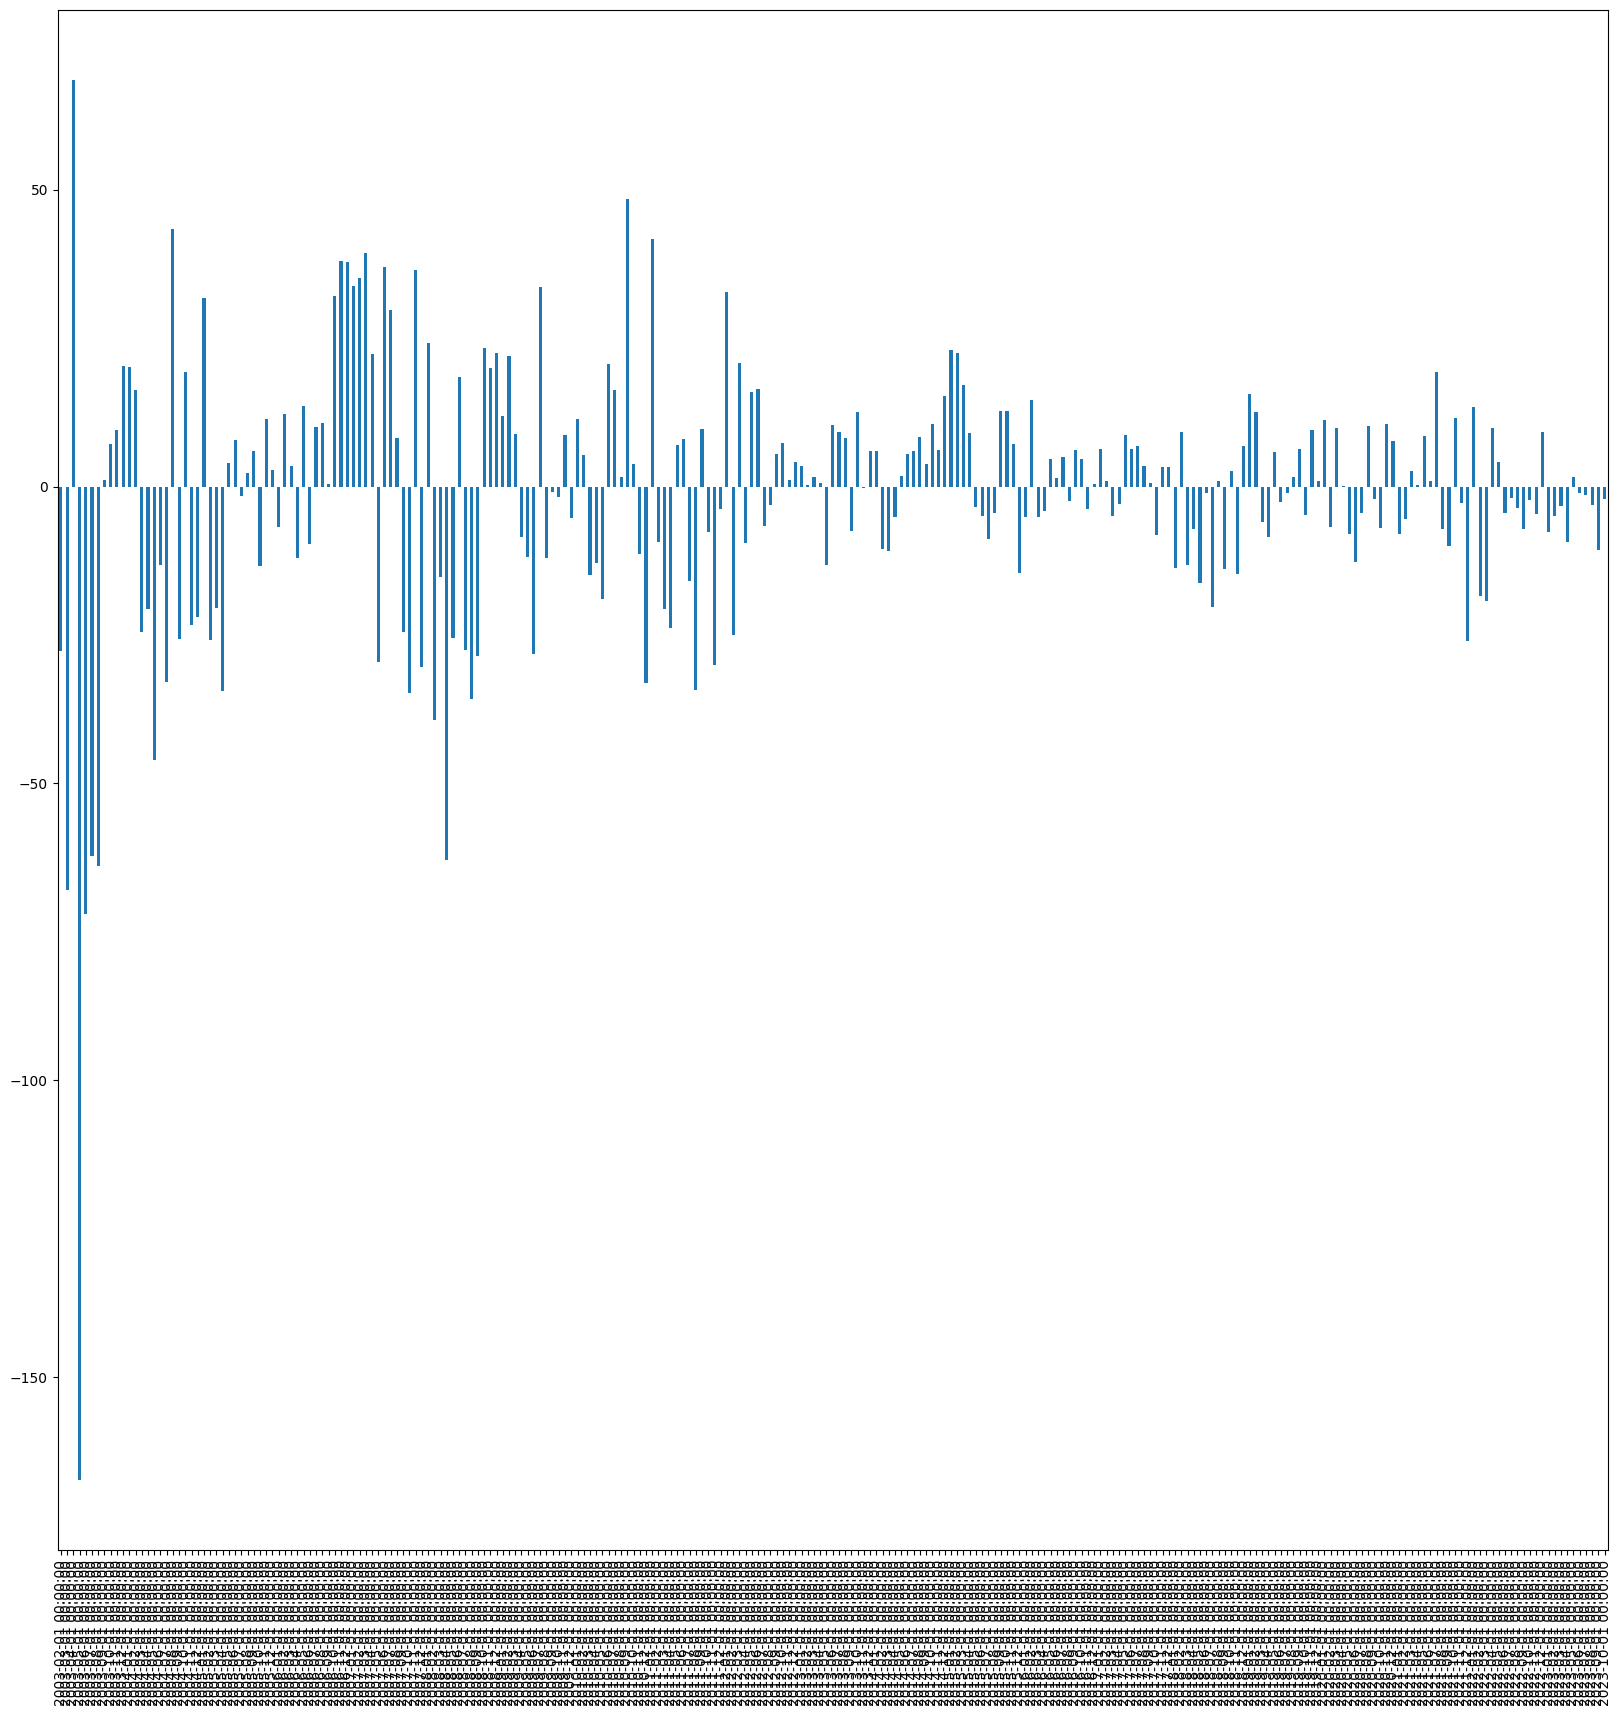

In [130]:
#t检验结果-冯婷玉
n = [x for x in WLS_t_test.values if np.abs(x)>1.96]
print('t值序列绝对值平均值——判断因子的显著性是否稳定',np.sum(np.abs(WLS_t_test.values))/len(WLS_t_test))
print('t值序列绝对值大于1.96的占比——判断因子的显著性是否稳定',len(n)/float(len(WLS_t_test)))
WLS_t_test.plot(kind='bar',figsize=(20,20))
# 储存结果-冯婷玉
plt.savefig(rf'./result/{file_name}/{file_name}_t.png')

IC 值序列的均值大小 0.000974372195479378
IC 值序列的标准差 0.0705097361659969
IR 比率（IC值序列均值与标准差的比值） 0.013818973782364909
IC 值序列大于零的占比 0.4738955823293173
IC 值序列绝对值大于0.02的占比 0.6947791164658634


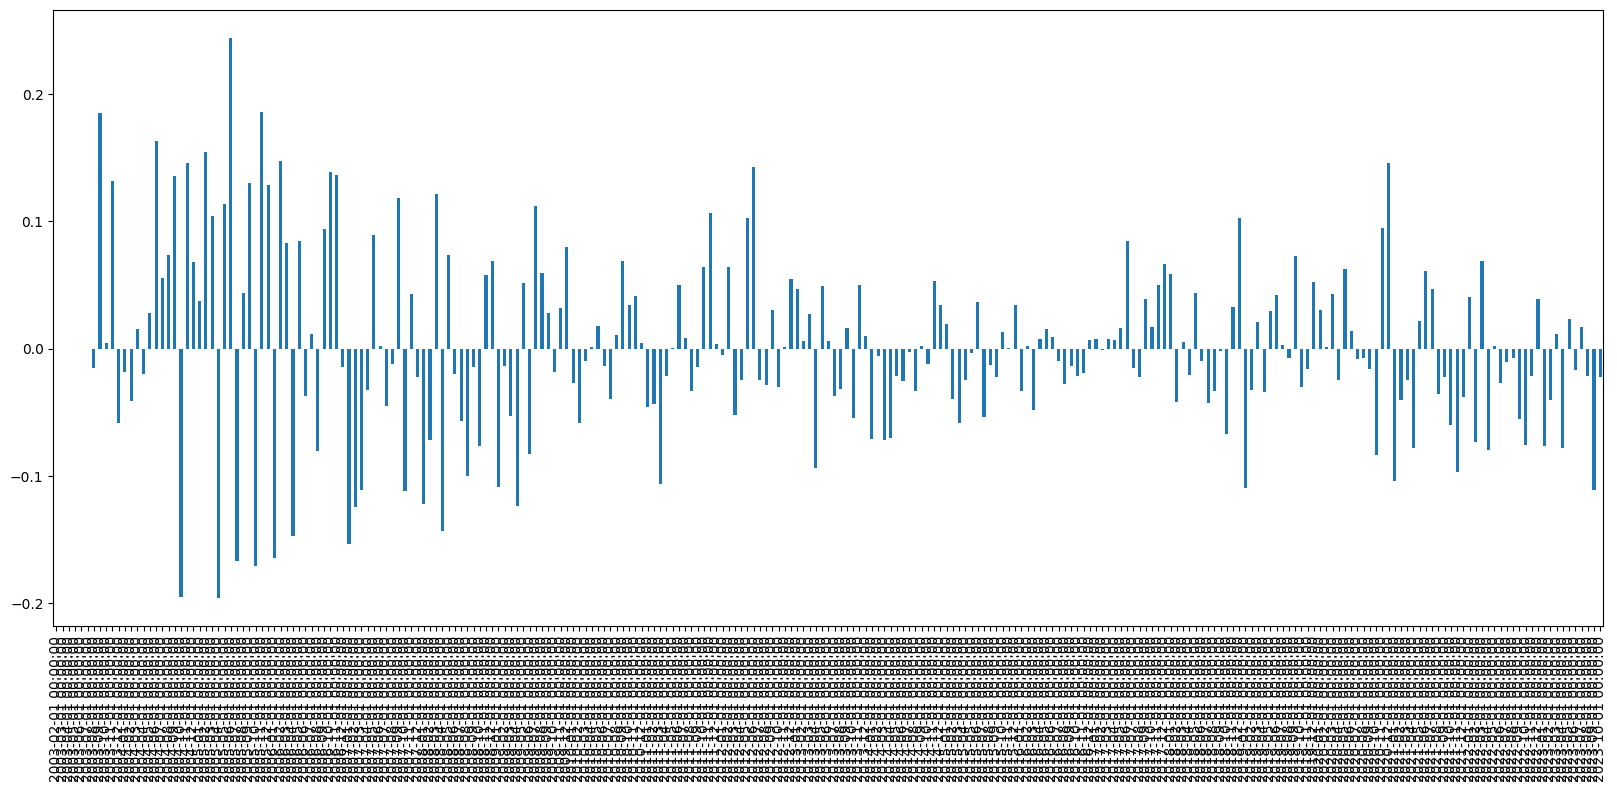

In [131]:
#IC检验结果-冯婷玉
print ('IC 值序列的均值大小',IC.mean())
print ('IC 值序列的标准差',IC.std())
print ('IR 比率（IC值序列均值与标准差的比值）',IC.mean()/IC.std())
n_1 = [x for x in IC.values if x > 0]
print ('IC 值序列大于零的占比',len(n_1)/float(len(IC)))

n_2 = [x for x in IC.values if np.abs(x) > 0.02]
print ('IC 值序列绝对值大于0.02的占比',len(n_2)/float(len(IC)))
IC.plot(kind='bar',figsize=(20,8))
# 储存结果-冯婷玉
plt.savefig(rf'./result/{file_name}/{file_name}_IC.png')

In [173]:
# 按照因子值大小分为十组-冯婷玉
group_data = {}

for group_num in range(1, 11):
    sign = group_num / 10
    print(sign)
    result = mainbody(factor_df, list(factor_df.columns), open_df, risk_free_file, freq=1, buy_sign=sign, group=1)
    group_data[f"Group{group_num}_factor_res"] = result[0]
    group_data[f"Group{group_num}_annual_returns"] = result[1]
    group_data[f"Group{group_num}_sharpe_ratio"] = result[2]
    group_data[f"Group{group_num}_maxdrawdown_rate"] = result[3]


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [202]:
## 分为十组
for group_num in range(1, 11):
    buy_num = group_num / 10
    group_factor_res, group_annual_returns, group_sharpe_ratio, group_maxdrawdown_rate = mainbody(factor_df, list(factor_df.columns), open_df, risk_free_file, freq=1, buy_sign=buy_num, group=group_num)
    
    locals()[f"Group{group_num}_factor_res"] = group_factor_res
    locals()[f"Group{group_num}_annual_returns"] = group_annual_returns
    locals()[f"Group{group_num}_sharpe_ratio"] = group_sharpe_ratio
    locals()[f"Group{group_num}_maxdrawdown_rate"] = group_maxdrawdown_rate



In [186]:
#获取前三组的资金曲线平均值减去后三组的资金曲线平均值，从数据上判断二者是否由显著差异-冯婷玉
returns_data = (Group1_factor_res + Group2_factor_res + Group3_factor_res) / 3 - (Group8_factor_res + Group9_factor_res + Group10_factor_res) / 3

In [203]:
#组间差异t检验，pvalue代表组间差异等于0的概率，pvalue = 8.4*10^-494，基本就等于0，说明组间差异显著异于0-冯婷玉
from scipy import stats
stats.ttest_1samp(return_data,0)

TtestResult(statistic=array([-17.9444377]), pvalue=array([8.37241864e-49]), df=array([287]))

In [218]:
## 储存结果-冯婷玉
results=pd.DataFrame(columns=['因子','股票数量','年化收益率','年化夏普率','最大回撤'])
for i in range(1,11):
    results.loc[len(results.index),:]=[f'Group{i}',len(factor_df.columns),eval(f'Group{i}_annual_returns'),
                                    eval(f'Group{i}_sharpe_ratio'),eval(f'Group{i}_maxdrawdown_rate')]
    
# result.to_csv(f'{facotr_name}_result_.csv',encoding='utf_8_sig',index=False)  
result.to_csv(rf'./result/{file_name}_result_group_.csv',encoding='utf_8_sig',index=False)  


In [210]:
###输出总图片（所有因子叠加在一起的图片）-冯婷玉

all_returns=eval(f'Group{i}_factor_res')
a=0
columns_name=['Group1']
for i in range(1,11): # 第一个因子已经merge到all_return中，因此只需从第二个开始merge
    all_returns=pd.merge(all_returns, eval(f'Group{i}_factor_res'),right_index=True,left_index=True,how='left')
    columns_name.append(f'Group{i}')
    all_returns.columns=columns_name
    a+=1

all_returns.plot(figsize=(15,6),grid=True,title='10 Groups Net Asset Value')
plt.legend(loc='best', labels=columns_name)
plt.savefig(rf'./result/{file_name}/{file_name}_All_Group.png')
plt.close()